# Semantic Image Clustering

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/02/28<br>
**Last modified:** 2021/02/28<br>
**Description:** Semantic Clustering by Adopting Nearest neighbors (SCAN) algorithm.

## Introduction

This example demonstrates how to apply the [Semantic Clustering by Adopting Nearest neighbors
(SCAN)](https://arxiv.org/abs/2005.12320) algorithm (Van Gansbeke et al., 2020) on the
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. The algorithm consists of
two phases:

1. Self-supervised visual representation learning of images, in which we use the
[simCLR](https://arxiv.org/abs/2002.05709) technique.
2. Clustering of the learned visual representation vectors to maximize the agreement
between the cluster assignments of neighboring vectors.

The example requires [TensorFlow Addons](https://www.tensorflow.org/addons),
which you can install using the following command:

```python
pip install tensorflow-addons
```

## Setup

In [ ]:
!pip install tensorflow==2.0.0-rc0

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:00


In [ ]:
from collections import defaultdict
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare the data

In [ ]:
import os
os.listdir('/content/drive/MyDrive/Inter_IIT/Cloudphysician/datasets/unlabelled_dataset_segmented')

In [ ]:
for i in x_data.take(2):
  print(i)

NameError: ignored

In [ ]:
num_classes = 40
input_shape = (256, 256, 3)

x_data = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Inter_IIT/Cloudphysician/datasets/unlabelled_dataset_segmented',labels=None)
# x_data = np.concatenate([x_train, x_test])
# y_data = np.concatenate([y_train, y_test])

# print("x_data shape:", x_data.shape)

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

Found 7000 files belonging to 1 classes.


In [ ]:
input_shape = (256, 256, 3)

## Define hyperparameters

In [ ]:
target_size = 32  # Resize the input images.
representation_dim = 512  # The dimensions of the features vector.
projection_units = 128  # The projection head of the representation learner.
num_clusters = 20  # Number of clusters.
k_neighbours = 5  # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.

## Implement data preprocessing

The data preprocessing step resizes the input images to the desired `target_size` and applies
feature-wise normalization. Note that, when using `keras.applications.ResNet50V2` as the
visual encoder, resizing the images into 255 x 255 inputs would lead to more accurate results
but require a longer time to train.

In [ ]:
data_preprocessing = keras.Sequential(
    [
        layers.Resizing(target_size, target_size),
        layers.Normalization(),
    ]
)
# Compute the mean and the variance from the data for normalization.
data_preprocessing.layers[-1].adapt(x_data)

## Data augmentation

Unlike simCLR, which randomly picks a single data augmentation function to apply to an input
image, we apply a set of data augmentation functions randomly to the input image.
(You can experiment with other image augmentation techniques by following
the [data augmentation tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"
        ),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(factor=0.15, fill_mode="nearest"),
        layers.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"
        ),
    ]
)

Display a random image

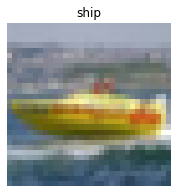

In [ ]:
image_idx = np.random.choice(range(x_data.shape[0]))
image = x_data[image_idx]
image_class = classes[y_data[image_idx][0]]
plt.figure(figsize=(3, 3))
plt.imshow(x_data[image_idx].astype("uint8"))
plt.title(image_class)
_ = plt.axis("off")

Display a sample of augmented versions of the image

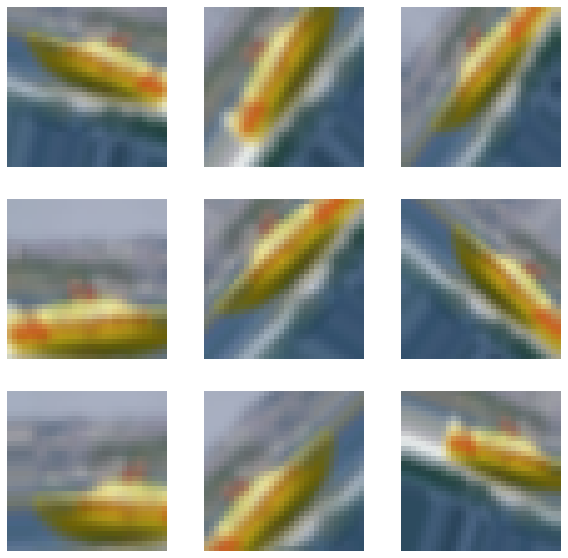

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_images = data_augmentation(np.array([image]))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Self-supervised representation learning

### Implement the vision encoder

In [ ]:

def create_encoder(representation_dim):
    encoder = keras.Sequential(
        [
            keras.applications.ResNet50V2(
                include_top=False, weights=None, pooling="avg"
            ),
            layers.Dense(representation_dim),
        ]
    )
    return encoder


### Implement the unsupervised contrastive loss

In [ ]:

class RepresentationLearner(keras.Model):
    def __init__(
        self,
        encoder,
        projection_units,
        num_augmentations,
        temperature=1.0,
        dropout_rate=0.1,
        l2_normalize=False,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.encoder = encoder
        # Create projection head.
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors, batch_size):
        num_augmentations = tf.shape(feature_vectors)[0] // batch_size
        if self.l2_normalize:
            feature_vectors = tf.math.l2_normalize(feature_vectors, -1)
        # The logits shape is [num_augmentations * batch_size, num_augmentations * batch_size].
        logits = (
            tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b=True)
            / self.temperature
        )
        # Apply log-max trick for numerical stability.
        logits_max = tf.math.reduce_max(logits, axis=1)
        logits = logits - logits_max
        # The shape of targets is [num_augmentations * batch_size, num_augmentations * batch_size].
        # targets is a matrix consits of num_augmentations submatrices of shape [batch_size * batch_size].
        # Each [batch_size * batch_size] submatrix is an identity matrix (diagonal entries are ones).
        targets = tf.tile(tf.eye(batch_size), [num_augmentations, num_augmentations])
        # Compute cross entropy loss
        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        # Preprocess the input images.
        preprocessed = data_preprocessing(inputs)
        # Create augmented versions of the images.
        augmented = []
        for _ in range(self.num_augmentations):
            augmented.append(data_augmentation(preprocessed))
        augmented = layers.Concatenate(axis=0)(augmented)
        # Generate embedding representations of the images.
        features = self.encoder(augmented)
        # Apply projection head.
        return self.projector(features)

    def train_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # Run the forward pass and compute the contrastive loss
        with tf.GradientTape() as tape:
            feature_vectors = self(inputs, training=True)
            loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update loss tracker metric
        self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        feature_vectors = self(inputs, training=False)
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


### Train the model

In [ ]:
# Create vision encoder.
encoder = create_encoder(representation_dim)
# Create representation learner.
representation_learner = RepresentationLearner(
    encoder, projection_units, num_augmentations=2, temperature=0.1
)
# Create a a Cosine decay learning rate scheduler.
lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=500, alpha=0.1
)
# Compile the model.
representation_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),
)
# Fit the model.
history = representation_learner.fit(
    x=x_data,
    batch_size=512,
    epochs=50,  # for better results, increase the number of epochs to 500.
)


Plot training loss

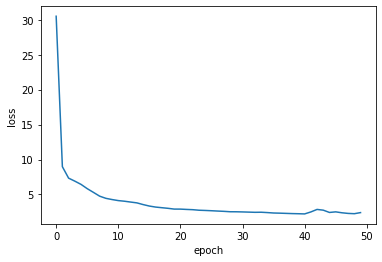

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

## Compute the nearest neighbors

### Generate the embeddings for the images

In [ ]:
batch_size = 500
# Get the feature vector representations of the images.
feature_vectors = encoder.predict(x_data, batch_size=batch_size, verbose=1)
# Normalize the feature vectores.
feature_vectors = tf.math.l2_normalize(feature_vectors, -1)

219/219 [==============================] - 33s 135ms/step


In [ ]:
representation_learner.save('/content/drive/MyDrive/Inter_IIT/Cloudphysician/model_embeddings')

In [ ]:
feature_vectors.numpy()

array([[-0.01929998, -0.01448135, -0.01310008, ..., -0.00121234,
         0.00668341, -0.03718389],
       [-0.01928007, -0.0144431 , -0.01311221, ..., -0.00122409,
         0.00672615, -0.03725267],
       [-0.01928782, -0.01447063, -0.01311655, ..., -0.00120803,
         0.00670306, -0.03721435],
       ...,
       [-0.0193308 , -0.01447486, -0.01308386, ..., -0.00119648,
         0.00669097, -0.03719334],
       [-0.01926138, -0.01445969, -0.01311972, ..., -0.00121774,
         0.00670166, -0.03721377],
       [-0.01932677, -0.01452128, -0.01311632, ..., -0.0011508 ,
         0.00663892, -0.03713866]], dtype=float32)

In [ ]:
feature_vectors.numpy().dump('/content/drive/MyDrive/Inter_IIT/Cloudphysician/feature_vector.pkl')

In [ ]:
import pickle
with open('/content/drive/MyDrive/Inter_IIT/Cloudphysician/feature_vector.pkl','w') as f:
  pickle.dump(feature_vectors.numpy(),f)

TypeError: ignored

### Find the *k* nearest neighbours for each embedding

In [ ]:
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = tf.math.top_k(similarities, k=k_neighbours + 1, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])

neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))

100%|██████████| 14/14 [00:00<00:00, 232.19it/s]


Let's display some neighbors on each row

In [ ]:
neighbours.shape

(7000, 5)

In [ ]:
nrows = 4
ncols = k_neighbours + 1

plt.figure(figsize=(12, 12))
position = 1
for _ in range(nrows):
    anchor_idx = np.random.choice(range(x_data.shape[0]))
    neighbour_indicies = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indicies.tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow(x_data[indices[j]].astype("uint8"))
        plt.title(classes[y_data[indices[j]][0]])
        plt.axis("off")
        position += 1

You notice that images on each row are visually similar, and belong to similar classes.

## Semantic clustering with nearest neighbours

### Implement clustering consistency loss

This loss tries to make sure that neighbours have the same clustering assignments.

In [ ]:

class ClustersConsistencyLoss(keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def __call__(self, target, similarity, sample_weight=None):
        # Set targets to be ones.
        target = tf.ones_like(similarity)
        # Compute cross entropy loss.
        loss = keras.losses.binary_crossentropy(
            y_true=target, y_pred=similarity, from_logits=True
        )
        return tf.math.reduce_mean(loss)


### Implement the clusters entropy loss

This loss tries to make sure that cluster distribution is roughly uniformed, to avoid
assigning most of the instances to one cluster.

In [ ]:

class ClustersEntropyLoss(keras.losses.Loss):
    def __init__(self, entropy_loss_weight=1.0):
        super().__init__()
        self.entropy_loss_weight = entropy_loss_weight

    def __call__(self, target, cluster_probabilities, sample_weight=None):
        # Ideal entropy = log(num_clusters).
        num_clusters = tf.cast(tf.shape(cluster_probabilities)[-1], tf.dtypes.float32)
        target = tf.math.log(num_clusters)
        # Compute the overall clusters distribution.
        cluster_probabilities = tf.math.reduce_mean(cluster_probabilities, axis=0)
        # Replacing zero probabilities - if any - with a very small value.
        cluster_probabilities = tf.clip_by_value(
            cluster_probabilities, clip_value_min=1e-8, clip_value_max=1.0
        )
        # Compute the entropy over the clusters.
        entropy = -tf.math.reduce_sum(
            cluster_probabilities * tf.math.log(cluster_probabilities)
        )
        # Compute the difference between the target and the actual.
        loss = target - entropy
        return loss


### Implement clustering model

This model takes a raw image as an input, generated its feature vector using the trained
encoder, and produces a probability distribution of the clusters given the feature vector
as the cluster assignments.

In [ ]:

def create_clustering_model(encoder, num_clusters, name=None):
    inputs = keras.Input(shape=input_shape)
    # Preprocess the input images.
    preprocessed = data_preprocessing(inputs)
    # Apply data augmentation to the images.
    augmented = data_augmentation(preprocessed)
    # Generate embedding representations of the images.
    features = encoder(augmented)
    # Assign the images to clusters.
    outputs = layers.Dense(units=num_clusters, activation="softmax")(features)
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model


### Implement clustering learner

This model receives the input `anchor` image and its `neighbours`, produces the clusters
assignments for them using the `clustering_model`, and produces two outputs:
1. `similarity`: the similarity between the cluster assignments of the `anchor` image and
its `neighbours`. This output is fed to the `ClustersConsistencyLoss`.
2. `anchor_clustering`: cluster assignments of the `anchor` images. This is fed to the `ClustersEntropyLoss`.

In [ ]:

def create_clustering_learner(clustering_model):
    anchor = keras.Input(shape=input_shape, name="anchors")
    neighbours = keras.Input(
        shape=tuple([k_neighbours]) + input_shape, name="neighbours"
    )
    # Changes neighbours shape to [batch_size * k_neighbours, width, height, channels]
    neighbours_reshaped = tf.reshape(neighbours, shape=tuple([-1]) + input_shape)
    # anchor_clustering shape: [batch_size, num_clusters]
    anchor_clustering = clustering_model(anchor)
    # neighbours_clustering shape: [batch_size * k_neighbours, num_clusters]
    neighbours_clustering = clustering_model(neighbours_reshaped)
    # Convert neighbours_clustering shape to [batch_size, k_neighbours, num_clusters]
    neighbours_clustering = tf.reshape(
        neighbours_clustering,
        shape=(-1, k_neighbours, tf.shape(neighbours_clustering)[-1]),
    )
    # similarity shape: [batch_size, 1, k_neighbours]
    similarity = tf.linalg.einsum(
        "bij,bkj->bik", tf.expand_dims(anchor_clustering, axis=1), neighbours_clustering
    )
    # similarity shape:  [batch_size, k_neighbours]
    similarity = layers.Lambda(lambda x: tf.squeeze(x, axis=1), name="similarity")(
        similarity
    )
    # Create the model.
    model = keras.Model(
        inputs=[anchor, neighbours],
        outputs=[similarity, anchor_clustering],
        name="clustering_learner",
    )
    return model


### Train model

In [ ]:
x_data

<BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [ ]:
# If tune_encoder_during_clustering is set to False,
# then freeze the encoder weights.
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering
# Create the clustering model and learner.
clustering_model = create_clustering_model(encoder, num_clusters, name="clustering")
clustering_learner = create_clustering_learner(clustering_model)
# Instantiate the model losses.
losses = [ClustersConsistencyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]
# Create the model inputs and labels.
inputs = {"anchors": x_data, "neighbours": tf.gather(x_data, neighbours)}
labels = tf.ones(shape=(x_data.shape[0]))
# Compile the model.
clustering_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
)

# Begin training the model.
clustering_learner.fit(x=inputs, y=labels, batch_size=512, epochs=50)

Plot training loss

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

## Cluster analysis

### Assign images to clusters

In [ ]:
# Get the cluster probability distribution of the input images.
clustering_probs = clustering_model.predict(x_data, batch_size=batch_size, verbose=1)
# Get the cluster of the highest probability.
cluster_assignments = tf.math.argmax(clustering_probs, axis=-1).numpy()
# Store the clustering confidence.
# Images with the highest clustering confidence are considered the 'prototypes'
# of the clusters.
cluster_confidence = tf.math.reduce_max(clustering_probs, axis=-1).numpy()

Let's compute the cluster sizes

In [ ]:
clusters = defaultdict(list)
for idx, c in enumerate(cluster_assignments):
    clusters[c].append((idx, cluster_confidence[idx]))

for c in range(num_clusters):
    print("cluster", c, ":", len(clusters[c]))

Notice that the clusters have roughly balanced sizes.

### Visualize cluster images

Display the *prototypes*—instances with the highest clustering confidence—of each cluster:

In [ ]:
num_images = 8
plt.figure(figsize=(15, 15))
position = 1
for c in range(num_clusters):
    cluster_instances = sorted(clusters[c], key=lambda kv: kv[1], reverse=True)

    for j in range(num_images):
        image_idx = cluster_instances[j][0]
        plt.subplot(num_clusters, num_images, position)
        plt.imshow(x_data[image_idx].astype("uint8"))
        plt.title(classes[y_data[image_idx][0]])
        plt.axis("off")
        position += 1

### Compute clustering accuracy

First, we assign a label for each cluster based on the majority label of its images.
Then, we compute the accuracy of each cluster by dividing the number of image with the
majority label by the size of the cluster.

In [ ]:
cluster_label_counts = dict()

for c in range(num_clusters):
    cluster_label_counts[c] = [0] * num_classes
    instances = clusters[c]
    for i, _ in instances:
        cluster_label_counts[c][y_data[i][0]] += 1

    cluster_label_idx = np.argmax(cluster_label_counts[c])
    correct_count = np.max(cluster_label_counts[c])
    cluster_size = len(clusters[c])
    accuracy = (
        np.round((correct_count / cluster_size) * 100, 2) if cluster_size > 0 else 0
    )
    cluster_label = classes[cluster_label_idx]
    print("cluster", c, "label is:", cluster_label, " -  accuracy:", accuracy, "%")

## Conclusion

To improve the accuracy results, you can: 1) increase the number
of epochs in the representation learning and the clustering phases; 2)
allow the encoder weights to be tuned during the clustering phase; and 3) perform a final
fine-tuning step through self-labeling, as described in the [original SCAN paper](https://arxiv.org/abs/2005.12320).
Note that unsupervised image clustering techniques are not expected to outperform the accuracy
of supervised image classification techniques, rather showing that they can learn the semantics
of the images and group them into clusters that are similar to their original classes.

**Example available on HuggingFace**
| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-Semantic%20Image%20Clustering-black.svg)](https://huggingface.co/keras-io/semantic-image-clustering) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-Semantic%20Image%20Clustering-black.svg)](https://huggingface.co/spaces/keras-io/semantic-image-clustering) |